# The goal of this document is to:

## 1. Prepare a transformed slice of bridge data for exploration and visualization. 

## 2. Prepare a transformed slice of bridge data for classification (make dummy variables, etc.)

## 3. Run CART, random forrest, and logistic regression classification models 

## 4. Retrieve relevant demographic variables from the ACS 2020 5 year estimates, map each census tract to the Municipality they belong to, and merge the demographic variables to each bridge data point based on Municipality

In [126]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from random import randrange
import warnings
import math
from sklearn import tree
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn

In [127]:
#Loading PA bridge dataset and filtering out bridges outside of Allegheny County
PA22 = pd.read_csv("PA22 - PA22.csv")
PA22_allegheny = PA22[PA22["COUNTY_CODE_003"] == 3]
PA22_allegheny.head()

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,BRIDGE_LEN_IND_112,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA
182,42,488,1,3,4,8,0,11,3,61000,...,Y,8,13300,2032,0.0,N,42,F,5,10462.97
183,42,491,1,3,1,8,1,11,3,24160,...,Y,N,12346,2032,0.0,N,42,F,5,1670.63
184,42,492,1,3,7,8,3,11,3,24160,...,Y,N,12878,2032,0.0,N,42,F,5,1596.00
185,42,495,1,3,1,8,0,11,3,69584,...,Y,4,25224,2032,0.0,N,42,F,5,638.82
186,42,496,1,3,1,8,0,11,3,69584,...,Y,4,25224,2032,0.0,N,42,F,5,410.04


## 1.  Prepare a transformed slice of bridge data for exploration and visualizetion. 

The dataset contains many numerical categorical variables that are not intuitive or easy to remember, we also discovered some redundancy. Although CART will require categorical data to be in numerical format, creating new categorical variables will reduce some redundancy and clarify the meaning of the features being selected. We will then create dummy variables.

In [128]:
#Variables most relevant to bridge condition prediction
relevant_variables = ['PLACE_CODE_004', 'TOLL_020', 'MAINTENANCE_021',  'FUNCTIONAL_CLASS_026', 
                     'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034',
                      'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'MAIN_UNIT_SPANS_045', 
                      'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                      'CHANNEL_COND_061', 'DATE_OF_INSPECT_090', 'INSPECT_FREQ_MONTHS_091',
                      'HIGHWAY_SYSTEM_104', 'HIGHWAY_SYSTEM_104', 'DECK_STRUCTURE_TYPE_107', 
                      'SURFACE_TYPE_108A', 'MEMBRANE_TYPE_108B', 'DECK_PROTECTION_108C', 
                      'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA']

#Creating a bridge dataset of variables for 'bridge-alone' classification models
Bridges_class = PA22_allegheny[PA22_allegheny.columns.intersection(relevant_variables)]
Bridges_class.head(n=7)


,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,...,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
182,61000,3,1,14,1960,4,13887,99,4,9,...,1020,24,1,1,1,0,1,4.0,F,10462.97
183,24160,3,1,14,1960,2,16758,99,3,2,...,1020,24,1,1,1,0,1,10.0,F,1670.63
184,24160,3,1,14,1960,1,16107,99,3,2,...,1020,24,1,1,1,0,1,9.0,F,1596.00
185,69584,3,1,14,1925,4,32865,45,1,11,...,1019,24,1,N,N,N,N,10.0,F,638.82
186,69584,3,1,14,1925,4,32865,5,1,11,...,1019,24,1,N,N,N,N,10.0,F,410.04
187,69584,3,1,14,1912,4,21271,30,1,11,...,1019,24,1,N,N,N,N,9.0,F,316.80
188,69584,3,1,14,1933,4,21271,30,3,2,...,1019,24,1,1,6,0,0,9.0,F,316.59


In [129]:
Bridges_class.describe(include = 'all')
#Categorical values
#Bridges_class[['TOLL_020']].mean()

,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,...,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
count,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294.000000,1294.000000,1294,1294,1294,1294,1293.000000,1294,1294.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,9,7,7,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,0,1,NaN,F,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,942,594,973,699,NaN,781,NaN
mean,49253.84544,2.948995,4.070325,14.506182,1965.890263,2.42813,12342.000773,26.336940,3.258887,6.070325,...,683.085781,25.569552,0.481453,NaN,NaN,NaN,NaN,6.858469,NaN,1160.069776
std,20146.21782,0.255842,7.902959,3.580199,31.424179,1.11546,15761.580475,29.987121,1.632584,5.919713,...,288.751436,5.950377,0.499849,NaN,NaN,NaN,NaN,4.700891,NaN,2237.708729
min,724.00000,1.000000,1.000000,1.000000,1841.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,120.000000,23.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,27.740000
25%,32328.00000,3.000000,1.000000,11.000000,1946.250000,2.00000,2041.000000,0.000000,2.000000,2.000000,...,518.000000,24.000000,0.000000,NaN,NaN,NaN,NaN,5.000000,NaN,132.860000
50%,56384.00000,3.000000,1.000000,14.000000,1966.000000,2.00000,6583.000000,17.000000,3.000000,3.000000,...,621.000000,24.000000,0.000000,NaN,NaN,NaN,NaN,6.000000,NaN,398.120000
75%,61000.00000,3.000000,2.000000,17.000000,1988.000000,3.00000,17445.000000,43.000000,4.000000,7.000000,...,921.000000,24.000000,1.000000,NaN,NaN,NaN,NaN,8.000000,NaN,1252.555000


In [130]:
#Creates new column based on data dictionarys 

#TOLL_020 
Toll = {1:1, 2:1, 3:1, 4:1, 5:1}  

#MAINTENANCE_021 
#Note that more than one agency can share the responsibility of bridge maintenance, in these cases the agency 
#with the highest hieracrchy within that responsibility is listed (e.g. if both municipal and state share 
#responsibilities state will be listed). #According to the output in the chunk above, none of the bridges 
#in AC have a maintenace code above 31. For our purposes, highway and toll authority are grouped together 

Maintenance = {1: 'State', 2: 'County', 3: 'Municipal', 4: 'Municipal', 11: 'State', 12: 'Municipal', 
               21: 'State', 25: 'Municipal', 26: 'Private', 27: 'Railroad', 31: 'State', 
               32: 'Municipal'}

#FUNCTIONAL_CLASS_026
#Creating Urban category based on the FUNCTIONAL_CLASS data dictionary
Urban = {1:0,2:0,6:0,7:0,8:0,9:0,11:1,12:1,14:1,16:1,17:1,19:1}

#FUNCTIONAL_CLASS_026
Function = {1: 'Interstate Principal Arterial', 2: 'Other Principal Arterial', 6: 'Minor Arterial', 
            7: 'Major Collector', 8: 'Minor Collector', 9: 'Municipal', 11: 'Interstate Principal Arterial', 
            12: 'Other Principal Arterial Freeways', 14: 'Other Principal Arterial', 16: 'Minor Arterial',
            17: 'Collector', 19: 'Municipal'}

#STRUCTURE_KIND_043A
Structure_Kind = {1: 'Concrete', 2: 'Concrete continuous', 3: 'Steel', 4: 'Steel continuous', 5: 'Prestressed concrete', 
                  6: 'Prestressed concrete continuous', 7: 'Wood', 8: 'Masonary', 9: 'Aluminum', 0: 'Other'}

#STRUCTURE_TYPE_043B
Structure_Type = {1: 'Slab', 2: 'Stringer or Girder', 3: 'Girder and floorbeam', 4: 'Tee beam', 
                  5: 'Multiple box beams or girders', 6: 'Single box beam or girder', 7: 'Frame', 
                  8: 'Orthotropic', 9: 'Truss - Deck', 10: 'Truss - Thru', 11: 'Arch - Deck',
                  12: 'Arch - Thru', 13: 'Suspension', 14: 'Stayed Girder', 15: 'Movable - Lift',
                  16: 'Movable - Bascule', 17: 'Movable - Swing', 18: 'Tunnel', 19: 'Culvert',
                  20: 'Mixed types', 21: 'Segmental Box Girder', 22: 'Channel Beam', 0: 'Other'}

#DECK_STRUCTURE_TYPE_107
Deck = {'N': 0, '1': 1, '2': 1, '3': 1, '4': 1, '5':1, '6': 1, '7': 1, '8': 1, '9': 1}

Deck_Structure = {'N': 'No deck', '1': 'Concrete Cast-in-Place', '2': 'Concrete Precast Panels', 
                  '3': 'Open Grating', '4': 'Closed Grating', '5': 'Steel plate', '6': 'Corrugated Steel', 
                  '7': 'Aluminum', '8': 'Wood', '9': 'Other'}

#SURFACE_TYPE_108A
Surface_Type = {'N': 'No deck', '0': 'None', '1': 'Monolithic Concrete', '2': ' Integral Concrete', '3': 'Latex Concrete', 
                '4': 'Low Slump Concrete', '5': 'Epoxy Overlay', '6': 'Bituminous', '7': 'Wood', 
                '8': 'Gravel', '9': 'Other'}

#MEMBRANE_TYPE_108B
Membrane_Type = {'N': 'No deck','0': 'None', '1': 'Built-up', '2': 'Preformed Fabric', '3': 'Epoxy', '8': 'Unknown',
                 '9': 'Other'}

#DECK_PROTECTION_108C
Deck_Protect = {'N': 'No deck','0': 'None', '1': 'Epoxy Coated', '2': 'Galvanized', '3': 'Other Coated Reinforcing', 
                '4': 'Cathodic Protection', '6': 'Polymer Impregnated', '7': 'Internally Sealed', 
                '8': 'Unknown', '9': 'Other', }

In [131]:
#Using dictionaries to create new columns that are easier to interpret for the reader
new_variables = [ 'Age', 'Toll','Urban','Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 
                 'Deck_Structure', 'Surface_Type', 'Membrane_Type', 'Deck_Protect', 'Deck']

Bridges_class['Toll'] = Bridges_class['TOLL_020'].map(Toll)
Bridges_class['Maintenance'] = Bridges_class['MAINTENANCE_021'].map(Maintenance)
Bridges_class['Urban'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Urban)
Bridges_class['Function'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Function)
Bridges_class['Structure_Kind'] = Bridges_class['STRUCTURE_KIND_043A'].map(Structure_Kind)
Bridges_class['Structure_Type'] = Bridges_class['STRUCTURE_TYPE_043B'].map(Structure_Type)
Bridges_class['Deck_Structure'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck_Structure)
Bridges_class['Deck'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck)
Bridges_class['Surface_Type'] = Bridges_class['SURFACE_TYPE_108A'].map(Surface_Type)
Bridges_class['Membrane_Type'] = Bridges_class['MEMBRANE_TYPE_108B'].map(Membrane_Type)
Bridges_class['Deck_Protect'] = Bridges_class['DECK_PROTECTION_108C'].map(Deck_Protect)
Bridges_class['Age'] = 2022 - Bridges_class['YEAR_BUILT_027']

Bridges_class[Bridges_class.columns.intersection(new_variables)].head()

,Toll,Maintenance,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,1,State,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [132]:
#Change new categorical variable into category data type 
category_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 'Surface_Type', 
                'Membrane_Type', 'Deck_Protect'] 
#Values need to be 'category' dtype to make dummy variables

for var in category_vars:
     Bridges_class[var] = Bridges_class[var].astype('category')
Bridges_class[Bridges_class.columns.intersection(category_vars)].head()

,Maintenance,Function,Structure_Kind,Structure_Type,Deck_Structure,Surface_Type,Membrane_Type,Deck_Protect
182,State,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
183,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
184,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
185,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck
186,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck


In [133]:
#List of all variables that will be considered for classification. See report.  
all_variables = new_variables + ['PLACE_CODE_004','TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034', 
                                 'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                                 'MAIN_UNIT_SPANS_045','INSPECT_FREQ_MONTHS_091','HIGHWAY_SYSTEM_104', 
                                 'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA'] 

                                    
Bridges_class_v2 = Bridges_class[Bridges_class.columns.intersection(all_variables)]
Bridges_class_v2.head()
#MAX_SPAN_LEN_MT_048, STRUCTURE_LEN_MT_049, ROADWAY_WIDTH_MT_051 and others need to be transformed because last digit is a tenth
# For example Length of Maximum Span 35.5 meters 00355

,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,...,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,61000,4,13887,99,4,121.9,641.9,15.2,24,1,...,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,24160,2,16758,99,11,26.8,235.3,6.0,24,1,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,24160,1,16107,99,11,25.9,212.8,6.4,24,1,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,69584,4,32865,45,1,21.0,33.8,15.3,24,1,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,69584,4,32865,5,1,20.4,20.4,17.5,24,1,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [134]:
#All continuous variables have to be normalized: ADT_029, DEGREES_SKEW_034,MAIN_UNIT_SPANS_045, MAX_SPAN_LEN_MT_048,
#ROADWAY_WIDTH_MT_051, etc
continous_var = ['Age','ADT_029', 'DEGREES_SKEW_034', 'TRAFFIC_LANES_ON_028A', 'MAIN_UNIT_SPANS_045', 
                 'MAX_SPAN_LEN_MT_048', 'ROADWAY_WIDTH_MT_051', 'STRUCTURE_LEN_MT_049', 'DECK_AREA', 
                 'INSPECT_FREQ_MONTHS_091', 'PERCENT_ADT_TRUCK_109']

def normalize(df, features):
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

Bridges_class_norm = normalize(Bridges_class_v2, continous_var)


In [135]:
Bridges_class_norm.describe(include='all')

,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,...,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
count,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294,1294,1294,1294,1294.000000,1294,1294,1294,1294.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8,10,16,9,NaN,9,7,7,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Municipal,Steel,Stringer or Girder,Concrete Cast-in-Place,NaN,Monolithic Concrete,None,Epoxy Coated,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,361,401,563,942,NaN,594,973,699,NaN
mean,49253.84544,0.204019,0.117318,0.266030,0.037205,0.107884,0.053992,0.223325,0.102782,0.481453,...,0.926584,NaN,NaN,NaN,NaN,0.782071,NaN,NaN,NaN,0.306165
std,20146.21782,0.159351,0.149823,0.302900,0.083232,0.128426,0.096896,0.131334,0.238015,0.499849,...,0.260919,NaN,NaN,NaN,NaN,0.412998,NaN,NaN,NaN,0.174579
min,724.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,32328.00000,0.142857,0.019401,0.000000,0.000000,0.027050,0.003336,0.155650,0.040000,0.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.183333
50%,56384.00000,0.142857,0.062575,0.171717,0.000000,0.069738,0.015230,0.208955,0.040000,0.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.305556
75%,61000.00000,0.285714,0.165825,0.434343,0.057143,0.135249,0.056295,0.272921,0.040000,1.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.415278


<AxesSubplot:>

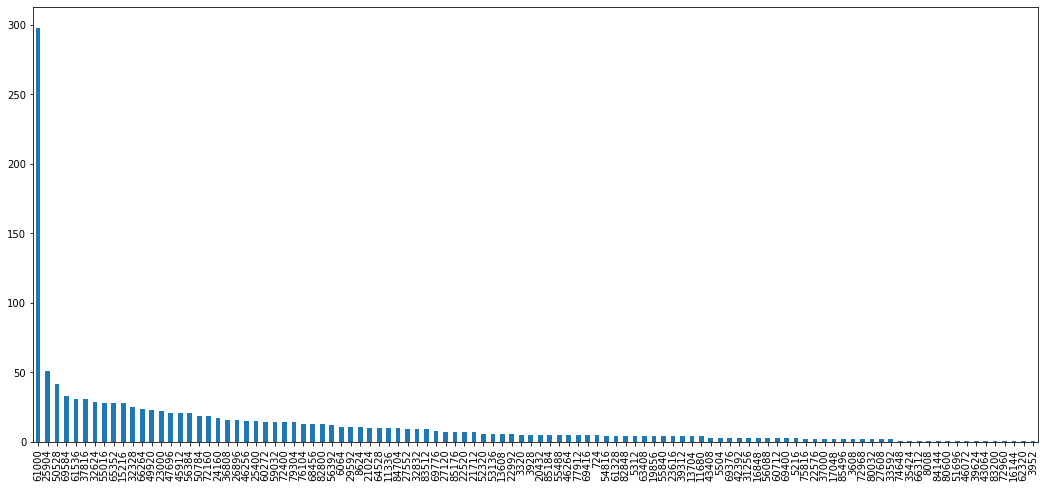

In [136]:
Bridges_class_norm['PLACE_CODE_004'].value_counts().plot(kind='bar', figsize=(18,8)) #Number of bridges by municipality

<AxesSubplot:>

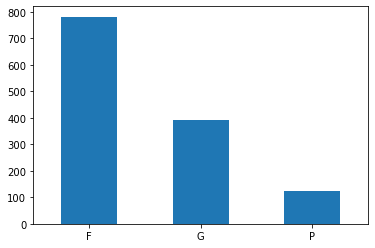

In [137]:
Bridges_class_norm['BRIDGE_CONDITION'].value_counts().plot.bar(rot=0) #bridges by condition


<AxesSubplot:>

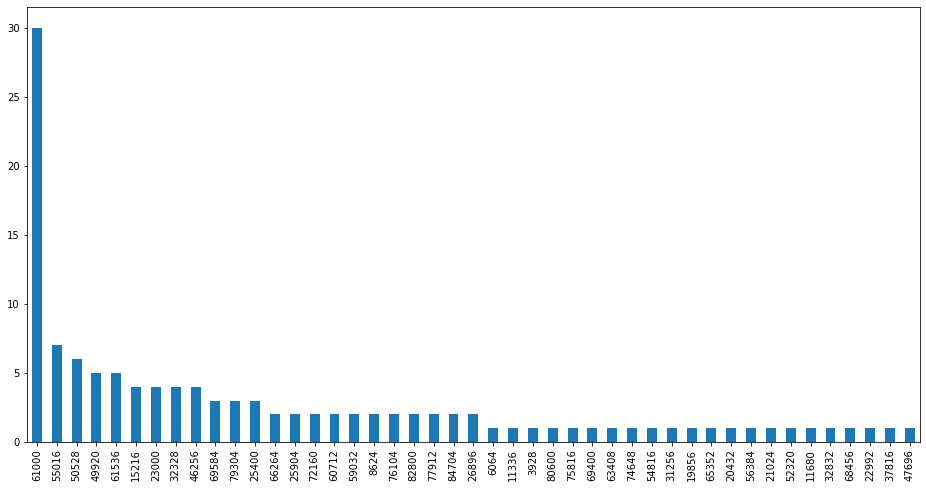

In [138]:
poor_bridges = Bridges_class_norm.loc[Bridges_class_norm['BRIDGE_CONDITION'] == 'P'] #bridges with poor bridge condition rating
poor_bridges['PLACE_CODE_004'].value_counts().plot(kind='bar', figsize=(16,8)) #poor bridges by place (FIPS municipality code)

## More data visualization and exploration

# 2. Data prep for classification models

In [139]:
dummy_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 
              'Surface_Type', 'Membrane_Type', 'Deck_Protect']
drop_columns = []
def prep_bridge_class_norm(df, dummy_vars, drop_columns):
    df = df.drop(columns = drop_columns) 
    result = {'P':0, 'F':1, 'G':1}  #Poor bridges are 0, fair and good are 1, found models are more accurate 
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('string')
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].map(result)
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('uint8')
    df['PERCENT_ADT_TRUCK_109'] = df['PERCENT_ADT_TRUCK_109'].fillna(0) #missing percent average dailt traffic truck is 0
    all_variables = list(df.columns)
    other_vars = [x for x in all_variables if x not in dummy_vars]
    df2 = pd.get_dummies(df[dummy_vars])
    df3 = pd.concat([df[other_vars], df2], axis=1) #concatenates continous variables with dummy variables
    return df3

In [140]:
df = prep_bridge_class_norm(Bridges_class_norm, dummy_vars, drop_columns)

#Function creates a correlation matrix and displays
def corr_check(df):
    corr_mat = df.corr().abs()
    sorted_mat = corr_mat.unstack().sort_values(ascending=False)
    print (sorted_mat.head(n=20))

In [141]:
corr_check(df)

Deck_Structure_No deck                          Deck                                              1.0
Deck                                            Deck_Structure_No deck                            1.0
PLACE_CODE_004                                  PLACE_CODE_004                                    1.0
Function_Major Collector                        Function_Major Collector                          1.0
Function_Minor Collector                        Function_Minor Collector                          1.0
Function_Municipal                              Function_Municipal                                1.0
Function_Other Principal Arterial               Function_Other Principal Arterial                 1.0
Function_Other Principal Arterial Freeways      Function_Other Principal Arterial Freeways        1.0
Structure_Kind_Aluminum                         Structure_Kind_Aluminum                           1.0
Structure_Kind_Concrete                         Structure_Kind_Concrete           

### Removes some of the highly correlated values

In [142]:
df.drop(columns = ['Deck_Structure_No deck'])

,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,...,Membrane_Type_Other,Membrane_Type_Preformed Fabric,Membrane_Type_Unknown,Deck_Protect_Epoxy Coated,Deck_Protect_Galvanized,Deck_Protect_No deck,Deck_Protect_None,Deck_Protect_Other,Deck_Protect_Other Coated Reinforcing,Deck_Protect_Unknown
182,61000,0.428571,0.132004,1.000000,0.085714,0.503804,0.461092,0.324094,0.04,1,...,0,0,0,1,0,0,0,0,0,0
183,24160,0.142857,0.159295,1.000000,0.285714,0.101860,0.166219,0.127932,0.04,1,...,0,0,0,1,0,0,0,0,0,0
184,24160,0.000000,0.153107,1.000000,0.285714,0.098056,0.149902,0.136461,0.04,1,...,0,0,0,1,0,0,0,0,0,0
185,69584,0.428571,0.312402,0.454545,0.000000,0.077346,0.020088,0.326226,0.04,1,...,0,0,0,0,0,1,0,0,0,0
186,69584,0.428571,0.312402,0.050505,0.000000,0.074810,0.010371,0.373134,0.04,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23023,72160,0.142857,0.000010,0.000000,0.057143,0.330093,0.147654,0.260128,0.04,0,...,0,0,0,1,0,0,0,0,0,0
23036,61536,0.142857,0.041787,0.353535,0.028571,0.128910,0.038436,0.208955,0.04,0,...,0,0,0,1,0,0,0,0,0,0
23078,61000,0.142857,0.507685,0.000000,1.000000,0.058326,0.425049,0.200426,0.04,1,...,0,0,0,1,0,0,0,0,0,0
23127,47696,0.428571,0.281195,0.666667,0.028571,0.155959,0.054391,0.390192,0.04,1,...,0,0,0,1,0,0,0,0,0,0


# Bridge Data with Demographic and socioeconomic variables 

#### 4. Retrieve relevant demographic and socioeconomic variables from the ACS 2020 5 year estimates. Map each census tract to the municipality they belong to. Aggregate these variables at municipality level and obtain summary statistics for each municipality. Mrge the summarized socioeconomic and demographic statistics to each bridge data point based on municipality

IMPORTANT NOTE: Census tracts must stay within a county and therefore a state. They do not necessarily coincide within any other geography. For example, although some census tracts follow place boundaries, there is no rule that says they must stay within a place. This explains why some same census tracts appear in different Municipalities
https://www.census.gov/newsroom/blogs/random-samplings/2014/07/understanding-geographic-relationships-counties-places-tracts-and-more.html<br>
Some municipalities will have nans, as there are not enough sample points in the census tracts.

In [143]:
#Read the excel file that contains the Census Tracts and the Municipality they belong to.
#Notice that Census Tracts in decimal format, e.g., XXXX.XX will be treated separately from Census Tracts in integer format
CensusTractdecimals_2020_Municipality = pd.read_excel("CensusTracts2020_Municipalities_AlleghenyCounty.xlsx", sheet_name = "Decimals")
CensusTractintegers_2020_Municipality = pd.read_excel("CensusTracts2020_Municipalities_AlleghenyCounty.xlsx", sheet_name = "Integers")

In [144]:
#Convert the census tract columns to string characters
CensusTractdecimals_2020_Municipality["CensusTract"] = CensusTractdecimals_2020_Municipality["CensusTract"].astype(str)
CensusTractintegers_2020_Municipality["CensusTract"] = CensusTractintegers_2020_Municipality["CensusTract"].astype(str)

In [145]:
#Create a dictionary, in which the keys are the census tracts and the values are the municipalities they belong to
CensusTracts_to_Municipality_dict = dict(zip(CensusTractintegers_2020_Municipality.CensusTract, CensusTractintegers_2020_Municipality.Municipality))
CensusTracts_to_Municipality_dict.update(dict(zip(CensusTractdecimals_2020_Municipality.CensusTract, CensusTractdecimals_2020_Municipality.Municipality)))

In [146]:
#Convert the keys of the dictionary to string characters
CensusTracts_to_Municipality_dict = {str(key): str(value) for key, value in CensusTracts_to_Municipality_dict.items()}

#### Read the census data and indicate to which Municipality each census tract belongs to

#### Race
#### Information was retrieved from ACS 2020 5-year estimates. This dataframe describes the population composition in terms of race for each census tract. Data will be aggregated at the municipality level. Notice that some census tracts may not contain data points. This is due to these reasons: 1) the number of sample cases is too small or 2) no sample observations available. In this case, nans are ignored when aggregating values at the municipality level. Value were aggregate by adding all census tracts statistics or averaging all census tracts statistics.  The dataframe at municipality level contains absolute estimates and percentages (with respect to the total population) of race composition. 

In [147]:
#Read the census data 
race_df = pd.read_excel("Total_Population_Race_2020.xlsx")

#Retrieve the census tract and save it as a string
race_df["GEO_ID_CensusTract"] = race_df.Geography.str[14:].astype(str).str.lstrip("0")

#Add decimal points
race_df["CensusTract(decimal format)"] = race_df["GEO_ID_CensusTract"].str[:-2]+'.'+race_df["GEO_ID_CensusTract"].str[-2:]

#Replace the .00 to ""
race_df["CensusTract(decimal format)"] = race_df["CensusTract(decimal format)"].astype(str)
race_df["CensusTract(decimal format)"] = race_df["CensusTract(decimal format)"].str.replace(".00", "", regex=False)

#Create a new column that indicates the Municipality to which each row of census data frame belongs to
race_df['Municipality'] = race_df["CensusTract(decimal format)"].map(CensusTracts_to_Municipality_dict)



In [148]:
#The following df contains the number of inhabitants in each municipality according to their race
Municipality_race_df = pd.pivot_table(race_df, values=['Total population', 
                                                    "Hispanic or Latino (of any race)", 
                                                    "White alone", 
                                                    "Black or African American alone", 
                                                    "American Indian and Alaska Native alone", 
                                                    "Asian alone", 
                                                    "Native Hawaiian and Other Pacific Islander alone",
                                                    "Some other race alone", 
                                                    "Two or more races"], 
                                   index=['Municipality'],
                                   aggfunc={'Total population': np.sum,
                                            "Hispanic or Latino (of any race)" : np.sum, 
                                             "White alone" : np.sum, 
                                             "Black or African American alone": np.sum, 
                                             "American Indian and Alaska Native alone": np.sum, 
                                             "Asian alone": np.sum, 
                                             "Native Hawaiian and Other Pacific Islander alone": np.sum,
                                             "Some other race alone": np.sum, 
                                             "Two or more races": np.sum})

#find percentages
Municipality_race_df["%Hispanic"] = (Municipality_race_df["Hispanic or Latino (of any race)"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%White alone"] = (Municipality_race_df["White alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%Black or African American alone"] = (Municipality_race_df["Black or African American alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%American Indian and Alaska Native alone"] = (Municipality_race_df["American Indian and Alaska Native alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%Asian alone"] = (Municipality_race_df["Asian alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%Native Hawaiian and Other Pacific Islander alone"] = (Municipality_race_df["Native Hawaiian and Other Pacific Islander alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%Some other race alone"] = (Municipality_race_df["Some other race alone"] / Municipality_race_df["Total population"]) * 100
Municipality_race_df["%Two or more races"] = (Municipality_race_df["Two or more races"] / Municipality_race_df["Total population"]) * 100


#### Economic characteristics
#### Information was retrieved from ACS 2020 5-year estimates. This dataframe provides information regarding the total number of civilian labor force, unemployment rate among civilian labor force, mean household income, total number of workers, the number of workers according to their of means of transportation to work. Data will be aggregated at the municipality level. Notice that some census tracts may not contain data points. This is due to these reasons: 1) the number of sample cases is too small or 2) no sample observations available. In this case, nans are ignored when aggregating values at the municipality level. Value were aggregate by adding all census tracts statistics or averaging all census tracts statistics.  The dataframe at municipality level contains absolute estimates and percentages (with respect to the total number of workers) 

In [149]:
#Read the census data 
econ_characs_df = pd.read_excel("Econ_Characs_2020_data.xlsx")

#Retrieve the census tract and save it as a string
econ_characs_df["GEO_ID_CensusTract"] = econ_characs_df.Geography.str[14:].astype(str).str.lstrip("0")

#Add decimal points
econ_characs_df["CensusTract(decimal format)"] = econ_characs_df["GEO_ID_CensusTract"].str[:-2]+'.'+econ_characs_df["GEO_ID_CensusTract"].str[-2:]

#Replace the .00 to ""
econ_characs_df["CensusTract(decimal format)"] = econ_characs_df["CensusTract(decimal format)"].astype(str)
econ_characs_df["CensusTract(decimal format)"] = econ_characs_df["CensusTract(decimal format)"].str.replace(".00", "", regex=False)

#Create a new column that indicates the Municipality to which each row of census data frame belongs to
econ_characs_df['Municipality'] = econ_characs_df["CensusTract(decimal format)"].map(CensusTracts_to_Municipality_dict)




In [150]:
#The following df contains the average unemployment rate, household income in each municipality
Municipality_economic_characs_df = pd.pivot_table(econ_characs_df, values=['Total civilian labor force',
                                                                          'Unemployment Rate among civilian labor force',
                                                                           'Mean household income (dollars)',
                                                                           'Total number workers 16 years and over',
                                                                           'Total workers that commute with car, truck, or van  drove alone',
                                                                           'Total workers that commute with car, truck, or van  carpooled',
                                                                           'Total workers that commute with public transportation (excluding taxicab)',
                                                                           'Total workers that walked',
                                                                           'Total workers that commute by other means',
                                                                            'Total workers that worked from home'], 
                                                                   index=['Municipality'],
                                                                   aggfunc={'Total civilian labor force': np.sum,
                                                                            'Unemployment Rate among civilian labor force' : np.mean,
                                                                            'Mean household income (dollars)' : np.mean, 
                                                                           'Total number workers 16 years and over': np.sum,
                                                                           'Total workers that commute with car, truck, or van  drove alone': np.sum,
                                                                           'Total workers that commute with car, truck, or van  carpooled': np.sum,
                                                                           'Total workers that commute with public transportation (excluding taxicab)': np.sum,
                                                                           'Total workers that walked': np.sum,
                                                                           'Total workers that commute by other means': np.sum,
                                                                            'Total workers that worked from home': np.sum})

#Find percentages
econ_characs_df["%Total workers that commute with car, truck, or van  drove alone"] = (econ_characs_df["Total workers that commute with car, truck, or van  drove alone"] / econ_characs_df["Total number workers 16 years and over"]) * 100
econ_characs_df["%Total workers that commute with car, truck, or van  carpooled"] = (econ_characs_df["Total workers that commute with car, truck, or van  carpooled"] / econ_characs_df["Total number workers 16 years and over"]) * 100
econ_characs_df["%Total workers that commute with public transportation (excluding taxicab)"] = (econ_characs_df["Total workers that commute with public transportation (excluding taxicab)"] / econ_characs_df["Total number workers 16 years and over"]) * 100
econ_characs_df["%Total workers that walked"] = (econ_characs_df["Total workers that walked"] / econ_characs_df["Total number workers 16 years and over"]) * 100
econ_characs_df["%Total workers that commute by other means"] = (econ_characs_df["Total workers that commute by other means"] / econ_characs_df["Total number workers 16 years and over"]) * 100
econ_characs_df["%Total workers that worked from home"] = (econ_characs_df["Total workers that worked from home"] / econ_characs_df["Total number workers 16 years and over"]) * 100

#### Poverty information
#### Information was retrieved from ACS 2020 5-year estimates. This dataframe provides information regarding the total number of inhabitants living in poverty, and the number of inhabitants living below the poverty status at each census tract. Data will be aggregated at the municipality level. Notice that some census tracts may not contain data points. This is due to these reasons: 1) the number of sample cases is too small or 2) no sample observations available. In this case, nans are ignored when aggregating values at the municipality level. Value were aggregate by adding all census tracts statistics or averaging all census tracts statistics.  The dataframe at municipality level contains absolute estimates and percentages (with respect to the total population living in poverty status) 

In [151]:
#Read the census data 
poverty_status_df = pd.read_excel("PovertyStatus_data_2020.xlsx")

#Retrieve the census tract and save it as a string
poverty_status_df["GEO_ID_CensusTract"] = poverty_status_df.Geography.str[14:].astype(str).str.lstrip("0")

#Add decimal points
poverty_status_df["CensusTract(decimal format)"] = poverty_status_df["GEO_ID_CensusTract"].str[:-2]+'.'+poverty_status_df["GEO_ID_CensusTract"].str[-2:]

#Replace the .00 to ""
poverty_status_df["CensusTract(decimal format)"] = poverty_status_df["CensusTract(decimal format)"].astype(str)
poverty_status_df["CensusTract(decimal format)"] = poverty_status_df["CensusTract(decimal format)"].str.replace(".00", "", regex=False)

#Create a new column that indicates the Municipality to which each row of census data frame belongs to
poverty_status_df['Municipality'] = poverty_status_df["CensusTract(decimal format)"].map(CensusTracts_to_Municipality_dict)


In [152]:
#The following df contains number living in poverty and the number of people living below the poverty level
Municipality_poverty_df = pd.pivot_table(poverty_status_df, values=['Total population for whom poverty status is determined',
                                                                    'Total population for whom poverty status is determined (Below poverty level)'], 
                                                                   index=['Municipality'],
                                                                   aggfunc={'Total population for whom poverty status is determined' : np.sum,
                                                                            'Total population for whom poverty status is determined (Below poverty level)': np.sum})

Municipality_poverty_df["%Total population for whom poverty status is determined (Below poverty level)"] = (Municipality_poverty_df["Total population for whom poverty status is determined (Below poverty level)"]/Municipality_poverty_df["Total population for whom poverty status is determined"])*100

#### Educational attainment information
#### Information was retrieved from ACS 2020 5-year estimates. This dataframe provides information regarding the total number of households, the total population older than 25 years, and the population (older than 25 years old) with less than 9th grade. Data will be aggregated at the municipality level. Notice that some census tracts may not contain data points. This is due to these reasons: 1) the number of sample cases is too small or 2) no sample observations available. In this case, nans are ignored when aggregating values at the municipality level. Value were aggregate by adding all census tracts statistics or averaging all census tracts statistics.  The dataframe at municipality level contains absolute estimates and percentages (with respect to the total population older than 25 years) 

In [153]:
#Read the census data 
educational_attainment_df = pd.read_excel("EducationalAttainment_2020_data.xlsx")

#Retrieve the census tract and save it as a string
educational_attainment_df["GEO_ID_CensusTract"] = educational_attainment_df.Geography.str[14:].astype(str).str.lstrip("0")

#Add decimal points
educational_attainment_df["CensusTract(decimal format)"] = educational_attainment_df["GEO_ID_CensusTract"].str[:-2]+'.'+educational_attainment_df["GEO_ID_CensusTract"].str[-2:]

#Replace the .00 to ""
educational_attainment_df["CensusTract(decimal format)"] = educational_attainment_df["CensusTract(decimal format)"].astype(str)
educational_attainment_df["CensusTract(decimal format)"] = educational_attainment_df["CensusTract(decimal format)"].str.replace(".00", "", regex=False)

#Create a new column that indicates the Municipality to which each row of census data frame belongs to
educational_attainment_df['Municipality'] = educational_attainment_df["CensusTract(decimal format)"].map(CensusTracts_to_Municipality_dict)


In [154]:
#The following df contains the number of households, population of 25 years and over, and population with less than 9th grade completed
Municipality_educational_attainment_df = pd.pivot_table(educational_attainment_df, values=['Total number households',
                                                                    'Total population 25 years and over',
                                                                    'Total population 25 years and over with less than 9th grade'], 
                                                                   index=['Municipality'],
                                                                   aggfunc={'Total number households' : np.sum,
                                                                            'Total population 25 years and over': np.sum,
                                                                           'Total population 25 years and over with less than 9th grade' : np.sum})


#Find percentages
Municipality_educational_attainment_df["%Total population 25 years and over with less than 9th grade"] = (Municipality_educational_attainment_df["Total population 25 years and over with less than 9th grade"]/Municipality_educational_attainment_df["Total population 25 years and over"])*100



#### Merge the socioeconomic and demographic statistics of municipalities to the bridge dataset

In [155]:
#Read the file that contains the PA22 - 22 csv file with the municipality of Allegheny county where every bridge belongs to
Bridges_df = pd.read_csv("PA22 - PA22_Municipalities.csv")

In [156]:
#Join the 4 different df that contains demographic information about municipalities 
Bridges_Municipalities_Demographics_df = Bridges_df.merge(right = Municipality_educational_attainment_df, 
                                                       how = "left", 
                                                       left_on = "Municipality", 
                                                       right_on = "Municipality")

Bridges_Municipalities_Demographics_df = Bridges_Municipalities_Demographics_df.merge(right = Municipality_poverty_df, 
                                                       how = "left", 
                                                       left_on = "Municipality", 
                                                       right_on = "Municipality")

Bridges_Municipalities_Demographics_df = Bridges_Municipalities_Demographics_df.merge(right = Municipality_economic_characs_df, 
                                                       how = "left", 
                                                       left_on = "Municipality", 
                                                       right_on = "Municipality")

Bridges_Municipalities_Demographics_df = Bridges_Municipalities_Demographics_df.merge(right = Municipality_race_df, 
                                                       how = "left", 
                                                       left_on = "Municipality", 
                                                       right_on = "Municipality")

In [157]:
Bridges_Municipalities_Demographics_df

,Original_row_number,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,...,Two or more races,White alone,%Hispanic,%White alone,%Black or African American alone,%American Indian and Alaska Native alone,%Asian alone,%Native Hawaiian and Other Pacific Islander alone,%Some other race alone,%Two or more races
0,182,42,488,1,3,4,8,0,11,3,...,13197.0,323498.0,3.046302,69.570959,18.923848,0.095916,4.936235,0.019785,0.568829,2.838126
1,183,42,491,1,3,1,8,1,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,184,42,492,1,3,7,8,3,11,3,...,83.0,3703.0,0.000000,94.392047,0.433342,0.000000,1.452970,1.605914,0.000000,2.115728
3,185,42,495,1,3,1,8,0,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,186,42,496,1,3,1,8,0,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,23023,42,67830,1,8,7,50,0,11,3,...,172.0,10821.0,2.178007,88.602309,1.097192,0.000000,6.714157,0.000000,0.000000,1.408335
1290,23036,42,67876,1,4,1,<Null>,0,11,3,...,20.0,5980.0,0.198314,98.826640,0.115683,0.000000,0.347050,0.181788,0.000000,0.330524
1291,23078,42,68228,1,1,1,376,2,11,3,...,13197.0,323498.0,3.046302,69.570959,18.923848,0.095916,4.936235,0.019785,0.568829,2.838126
1292,23127,42,68593,1,8,1,76,0,11,3,...,148.0,6185.0,1.437066,76.622894,3.543112,0.000000,16.365213,0.000000,0.198216,1.833499


In [158]:
## This dataframe contains socioeconomic and demographic statistics and characteristics of each bridge. Lets merge this df
## with the df that has already been prepared
Bridges_Municipalities_Demographics_df = Bridges_Municipalities_Demographics_df[["Original_row_number","Municipality",
"Total number households",
"Total population 25 years and over",
"Total population 25 years and over with less than 9th grade",
"%Total population 25 years and over with less than 9th grade",
"Total population for whom poverty status is determined",
"Total population for whom poverty status is determined (Below poverty level)",
"%Total population for whom poverty status is determined (Below poverty level)",
"Mean household income (dollars)",
"Total civilian labor force",
"Total number workers 16 years and over",
"Total workers that commute by other means",
"Total workers that commute with car, truck, or van  carpooled",
"Total workers that commute with car, truck, or van  drove alone",
"Total workers that commute with public transportation (excluding taxicab)",
"Total workers that walked",
"Total workers that worked from home",
"Unemployment Rate among civilian labor force",
"American Indian and Alaska Native alone",
"Asian alone",
"Black or African American alone",
"Hispanic or Latino (of any race)",
"Native Hawaiian and Other Pacific Islander alone",
"Some other race alone",
"Total population",
"Two or more races",
"White alone",
"%Hispanic",
"%White alone",
"%Black or African American alone",
"%American Indian and Alaska Native alone",
"%Asian alone",
"%Native Hawaiian and Other Pacific Islander alone",
"%Some other race alone",
"%Two or more races"]]

In [159]:
df.reset_index(inplace=True)
df = df.merge(right = Bridges_Municipalities_Demographics_df,
             how = "inner", 
             left_on = "index", 
             right_on = "Original_row_number")

In [160]:
df

,index,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,...,Two or more races,White alone,%Hispanic,%White alone,%Black or African American alone,%American Indian and Alaska Native alone,%Asian alone,%Native Hawaiian and Other Pacific Islander alone,%Some other race alone,%Two or more races
0,182,61000,0.428571,0.132004,1.000000,0.085714,0.503804,0.461092,0.324094,0.04,...,13197.0,323498.0,3.046302,69.570959,18.923848,0.095916,4.936235,0.019785,0.568829,2.838126
1,183,24160,0.142857,0.159295,1.000000,0.285714,0.101860,0.166219,0.127932,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,184,24160,0.000000,0.153107,1.000000,0.285714,0.098056,0.149902,0.136461,0.04,...,83.0,3703.0,0.000000,94.392047,0.433342,0.000000,1.452970,1.605914,0.000000,2.115728
3,185,69584,0.428571,0.312402,0.454545,0.000000,0.077346,0.020088,0.326226,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,186,69584,0.428571,0.312402,0.050505,0.000000,0.074810,0.010371,0.373134,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,23023,72160,0.142857,0.000010,0.000000,0.057143,0.330093,0.147654,0.260128,0.04,...,172.0,10821.0,2.178007,88.602309,1.097192,0.000000,6.714157,0.000000,0.000000,1.408335
1290,23036,61536,0.142857,0.041787,0.353535,0.028571,0.128910,0.038436,0.208955,0.04,...,20.0,5980.0,0.198314,98.826640,0.115683,0.000000,0.347050,0.181788,0.000000,0.330524
1291,23078,61000,0.142857,0.507685,0.000000,1.000000,0.058326,0.425049,0.200426,0.04,...,13197.0,323498.0,3.046302,69.570959,18.923848,0.095916,4.936235,0.019785,0.568829,2.838126
1292,23127,47696,0.428571,0.281195,0.666667,0.028571,0.155959,0.054391,0.390192,0.04,...,148.0,6185.0,1.437066,76.622894,3.543112,0.000000,16.365213,0.000000,0.198216,1.833499


In [161]:
df.describe()

,index,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,...,Two or more races,White alone,%Hispanic,%White alone,%Black or African American alone,%American Indian and Alaska Native alone,%Asian alone,%Native Hawaiian and Other Pacific Islander alone,%Some other race alone,%Two or more races
count,1294.000000,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,4762.125966,49253.84544,0.204019,0.117318,0.266030,0.037205,0.107884,0.053992,0.223325,0.102782,...,4496.582974,113975.973060,1.923795,80.310792,10.974734,0.083862,3.722806,0.042829,0.485407,2.455775
std,7926.422103,20146.21782,0.159351,0.149823,0.302900,0.083232,0.128426,0.096896,0.131334,0.238015,...,5895.870722,141953.195699,0.982913,13.087640,11.400058,0.097772,2.814094,0.198082,0.657348,1.198623
min,182.000000,724.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.000000,623.000000,0.000000,32.369319,0.115683,0.000000,0.000000,0.000000,0.000000,0.330524
25%,505.250000,32328.00000,0.142857,0.019401,0.000000,0.000000,0.027050,0.003336,0.155650,0.040000,...,172.000000,7207.000000,1.218699,69.570959,1.834274,0.000000,1.780314,0.000000,0.106662,1.520123
50%,828.500000,56384.00000,0.142857,0.062575,0.171717,0.000000,0.069738,0.015230,0.208955,0.040000,...,467.000000,30781.000000,1.745832,85.602864,5.940086,0.095916,4.258003,0.000000,0.334197,2.838126
75%,1152.750000,61000.00000,0.285714,0.165825,0.434343,0.057143,0.135249,0.056295,0.272921,0.040000,...,13197.000000,323498.000000,3.046302,91.068240,18.923848,0.095916,4.936235,0.019785,0.568829,2.838126
max,23130.000000,85496.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,13197.000000,323498.000000,6.200655,98.826640,58.900665,0.951173,16.365213,1.605914,4.293263,8.549971


In [162]:
df[df.columns[90:]].info() # information for the socioeconomic and demographic data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 0 to 1293
Data columns (total 35 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Municipality                                                                   1294 non-null   object 
 1   Total number households                                                        928 non-null    float64
 2   Total population 25 years and over                                             928 non-null    float64
 3   Total population 25 years and over with less than 9th grade                    928 non-null    float64
 4   %Total population 25 years and over with less than 9th grade                   928 non-null    float64
 5   Total population for whom poverty status is determined                         928 non-null    float64
 6   Total population for who

In [163]:
#making sure that the missing data is the same across all columns
set(df.loc[df['%American Indian and Alaska Native alone'].isna(),
           'Municipality'])== set(df.loc[df['Mean household income (dollars)'].isna(), 'Municipality'])

True

In [164]:
#set(df.loc[df['%American Indian and Alaska Native alone'].isna(),'Municipality'])

In [165]:
df.dropna(inplace=True) #dropping all bridges with NaN values
df.drop('Municipality',axis=1,inplace=True) #dropping all bridges with NaN values

In [166]:
df['BRIDGE_CONDITION'].value_counts() # checking how many bridges we have from each class 

1    840
0     88
Name: BRIDGE_CONDITION, dtype: int64

In [167]:
#getting part of the socioeconomic and demographic for the poor bridges 
poor_bridges=df.loc[df['BRIDGE_CONDITION']==0,['Mean household income (dollars)'
                                  ,'Total population',
                                  'Total population for whom poverty status is determined (Below poverty level)',
                                  'Total population 25 years and over with less than 9th grade',
                                 '%White alone',
                                 '%Black or African American alone',
                                 'Unemployment Rate among civilian labor force']].mean()

In [168]:
#getting part of the socioeconomic and demographic for the good bridges 
good_bridges=df.loc[df['BRIDGE_CONDITION']==1,['Mean household income (dollars)','Total population',
                               'Total population for whom poverty status is determined (Below poverty level)',
                                  'Total population 25 years and over with less than 9th grade',
                                 '%White alone',
                                 '%Black or African American alone',
                                 'Unemployment Rate among civilian labor force']].mean()

In [169]:
#poor_bridges

In [170]:
combined_poor_good_data=pd.concat([good_bridges, poor_bridges], axis=1).reset_index() #one df for the data in the previous cells
combined_poor_good_data = combined_poor_good_data.rename(columns={0: 'good bridges', 1: 'poor bridges'})

In [171]:
combined_poor_good_data

,index,good bridges,poor bridges
0,Mean household income (dollars),92381.269328,84540.204533
1,Total population,159709.291667,169074.693182
2,Total population for whom poverty status is de...,23691.367857,25224.261364
3,Total population 25 years and over with less t...,2069.314286,2183.352273
4,%White alone,80.567013,77.865042
5,%Black or African American alone,10.704439,13.554820
6,Unemployment Rate among civilian labor force,4.999937,5.259340


<AxesSubplot:xlabel='index'>

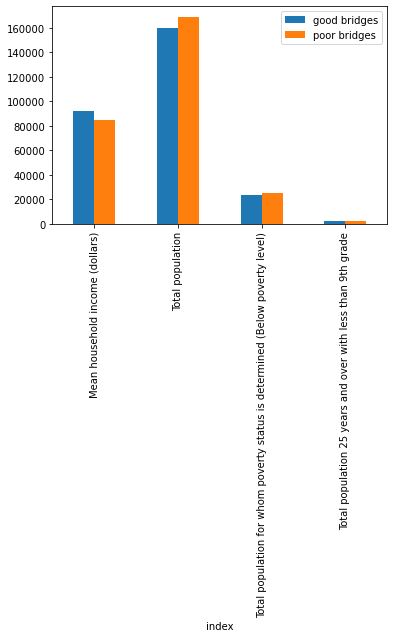

In [172]:
fig, ax = plt.subplots()
combined_poor_good_data[:4].plot.bar(x='index', ax=ax) #plotting the bar grpah of the first 4 coloumns 

<AxesSubplot:xlabel='index'>

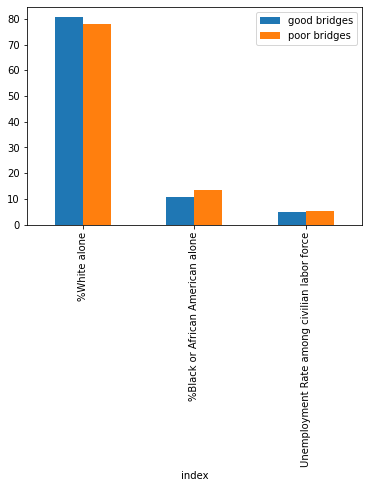

In [173]:
fig, ax = plt.subplots()
combined_poor_good_data[4:].plot.bar(x='index', ax=ax) #plotting the bar grpah of the coloumns 4 until the end

# Normalization of the socioeconomic and demographic data

In [174]:
continous_var=df.columns[90:] #include only demographic and socio econmoic data
df_norm=df.copy()
df_norm = normalize(df_norm, continous_var) #normalize the columns

In [175]:
df_norm.head(5)
df=df_norm
y = df.loc[:, df.columns =='BRIDGE_CONDITION']
X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
#y_train
for var in list(df.columns):   #Checks for any columns remaining that are not in the correct format (numerical)
    print(var, df[var].dtypes) 


index int64
PLACE_CODE_004 int64
TRAFFIC_LANES_ON_028A float64
ADT_029 float64
DEGREES_SKEW_034 float64
MAIN_UNIT_SPANS_045 float64
MAX_SPAN_LEN_MT_048 float64
STRUCTURE_LEN_MT_049 float64
ROADWAY_WIDTH_MT_051 float64
INSPECT_FREQ_MONTHS_091 float64
HIGHWAY_SYSTEM_104 int64
PERCENT_ADT_TRUCK_109 float64
BRIDGE_CONDITION uint8
DECK_AREA float64
Toll int64
Urban int64
Deck int64
Age float64
Maintenance_County uint8
Maintenance_Municipal uint8
Maintenance_Private uint8
Maintenance_Railroad uint8
Maintenance_State uint8
Function_Collector uint8
Function_Interstate Principal Arterial uint8
Function_Major Collector uint8
Function_Minor Arterial uint8
Function_Minor Collector uint8
Function_Municipal uint8
Function_Other Principal Arterial uint8
Function_Other Principal Arterial Freeways uint8
Structure_Kind_Aluminum uint8
Structure_Kind_Concrete uint8
Structure_Kind_Concrete continuous uint8
Structure_Kind_Masonary uint8
Structure_Kind_Other uint8
Structure_Kind_Prestressed concrete uint8
St

In [176]:
df['TRAFFIC_LANES_ON_028A']

0       0.428571
2       0.000000
8       0.142857
9       0.428571
14      0.142857
          ...   
1289    0.142857
1290    0.142857
1291    0.142857
1292    0.428571
1293    0.142857
Name: TRAFFIC_LANES_ON_028A, Length: 928, dtype: float64

# Models 

### 3.1 Random Forrest

In [177]:
def evaluate_randomforrest(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
#     columns = X_train.columns
#     #oversampling with SMOTE
#     oversample = SMOTE()
#     os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
#     X_train = pd.DataFrame(data=os_data_X,columns=columns)
#     y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    gsc = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid={'max_depth': range(2,9),
                                   'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100],
                                   'min_samples_split': range(2,10)},
                       cv = 5, #Default in function is 5, but kept this line for clarity 
                       scoring = 'accuracy', 
                       verbose = False,                         
                       n_jobs = 1)
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    model = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],
                                min_samples_split=best_params["min_samples_split"],
                                random_state=1, 
                                verbose=False)# K-Fold CV
    print('The best parameters are', best_params, '\n')
    for score in [None, 'precision', 'recall', 'f1']:
        value = cross_val_score(model, X_train, y_train, cv = 5, scoring = score) #default is accuracy
        if score == None:
            print('Average accuracy from K=5 cross validation is', round(mean(value),3), '\n')
        else:
            print('Average ', score, ' from K=5 cross validation is', round(mean(value),3), '\n')
    #fit the model
    model.fit(X_train, y_train)
    # make predictions
    yhat1 = model.predict(X_test)
    # evaluate predictions
    accuracy_score_test1 = accuracy_score(y_test, yhat1)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    yhat2 = model.predict(X_train)
    # evaluate predictions
    accuracy_score_test2 = accuracy_score(y_train, yhat2)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # View the classification report for test data and predictions
    print("\nClassification Report")
    print(classification_report(y_test, yhat1))
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,yhat1)
    print(matrix)

In [178]:
evaluate_randomforrest(df)


The best parameters are {'max_depth': 8, 'min_samples_split': 7, 'n_estimators': 8} 

Average accuracy from K=5 cross validation is 0.892 

Average  precision  from K=5 cross validation is 0.904 

Average  recall  from K=5 cross validation is 0.984 

Average  f1  from K=5 cross validation is 0.942 

Accuracy score for test data is: 0.939
Accuracy score for train data is: 0.948

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.16      0.26        19
           1       0.94      1.00      0.97       260

    accuracy                           0.94       279
   macro avg       0.85      0.58      0.61       279
weighted avg       0.93      0.94      0.92       279

Confusion Matrix
[[  3  16]
 [  1 259]]


# 3.2 CART model

In [179]:
#Need to figure out how to do cross validation of differen test sets 
def evaluate_CART(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    DecisionTree_for_GridSearch = DecisionTreeClassifier(random_state = 5)
    tree_gsearch = GridSearchCV(estimator = DecisionTree_for_GridSearch, 
                     param_grid = {"criterion" : ["gini", "entropy"], #Criterion indicates the function to measure the quality of a split
                                   "max_depth" : range(1,10), #Maximum depth of the tree
                                   "min_samples_leaf" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, None], #Minumum per leaf
                                   'min_samples_split': range(2,10)}, #The minimum number of obv per leaf node
                     cv = 5,  #CV will divide data randomly into 5 and cross validate
                     scoring = "accuracy")
    tree_gsearch.fit(X_train, y_train)
    best_params = tree_gsearch.best_params_
    best_score = tree_gsearch.best_score_
    print("The best parameters found are:", best_params, '\n')
    best_tree = tree_gsearch.best_estimator_
    model = DecisionTreeClassifier(random_state = 5,
                                   criterion = best_params['criterion'],
                                   max_depth=best_params["max_depth"], 
                                   min_samples_leaf=best_params["min_samples_leaf"],
                                   min_samples_split=best_params["min_samples_split"])
    for score in [None, 'precision', 'recall', 'f1']:
        value = cross_val_score(model, X, y, cv = 5, scoring = score) #default is accuracy
        if score == None:
            print('Average accuracy from K=5 cross validation is', round(mean(value),3), '\n')
        else:
            print('Average ', score, ' from K=5 cross validation is', round(mean(value),3), '\n')
    list_of_tuples = list(zip(X.columns, best_tree.feature_importances_))
    df2 = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Importance'])
    print(df2.nlargest(10, 'Importance')) #Find top 10 features by importance
    tree_fig = plt.figure(figsize=(50,50))
    _ = tree.plot_tree(decision_tree = best_tree,
                       filled=True,
                       rounded=True,
                       class_names=["Poor", "Fair_or_Good"],
                       feature_names = X.columns); 
    _
    #fit the model
    model.fit(X_train, y_train)
    # get accuracy
    accuracy_score_test1 = model.score(X_test, y_test)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    accuracy_score_test2 = model.score(X_train, y_train)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # make predictions
    yhat1 = model.predict(X_test)
    # View the classification report for test data and predictions
    print("\nClassification Report")
    print(classification_report(y_test, yhat1))
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,yhat1)
    print(matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, yhat1)

The best parameters found are: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2} 

Average accuracy from K=5 cross validation is 0.903 

Average  precision  from K=5 cross validation is 0.911 

Average  recall  from K=5 cross validation is 0.99 

Average  f1  from K=5 cross validation is 0.949 

                    Feature  Importance
66  Surface_Type_Bituminous    0.650770
4          DEGREES_SKEW_034    0.201583
16                      Age    0.147648
0                     index    0.000000
1            PLACE_CODE_004    0.000000
2     TRAFFIC_LANES_ON_028A    0.000000
3                   ADT_029    0.000000
5       MAIN_UNIT_SPANS_045    0.000000
6       MAX_SPAN_LEN_MT_048    0.000000
7      STRUCTURE_LEN_MT_049    0.000000
Accuracy score for test data is: 0.928
Accuracy score for train data is: 0.904

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.26      0.33        19
           1  

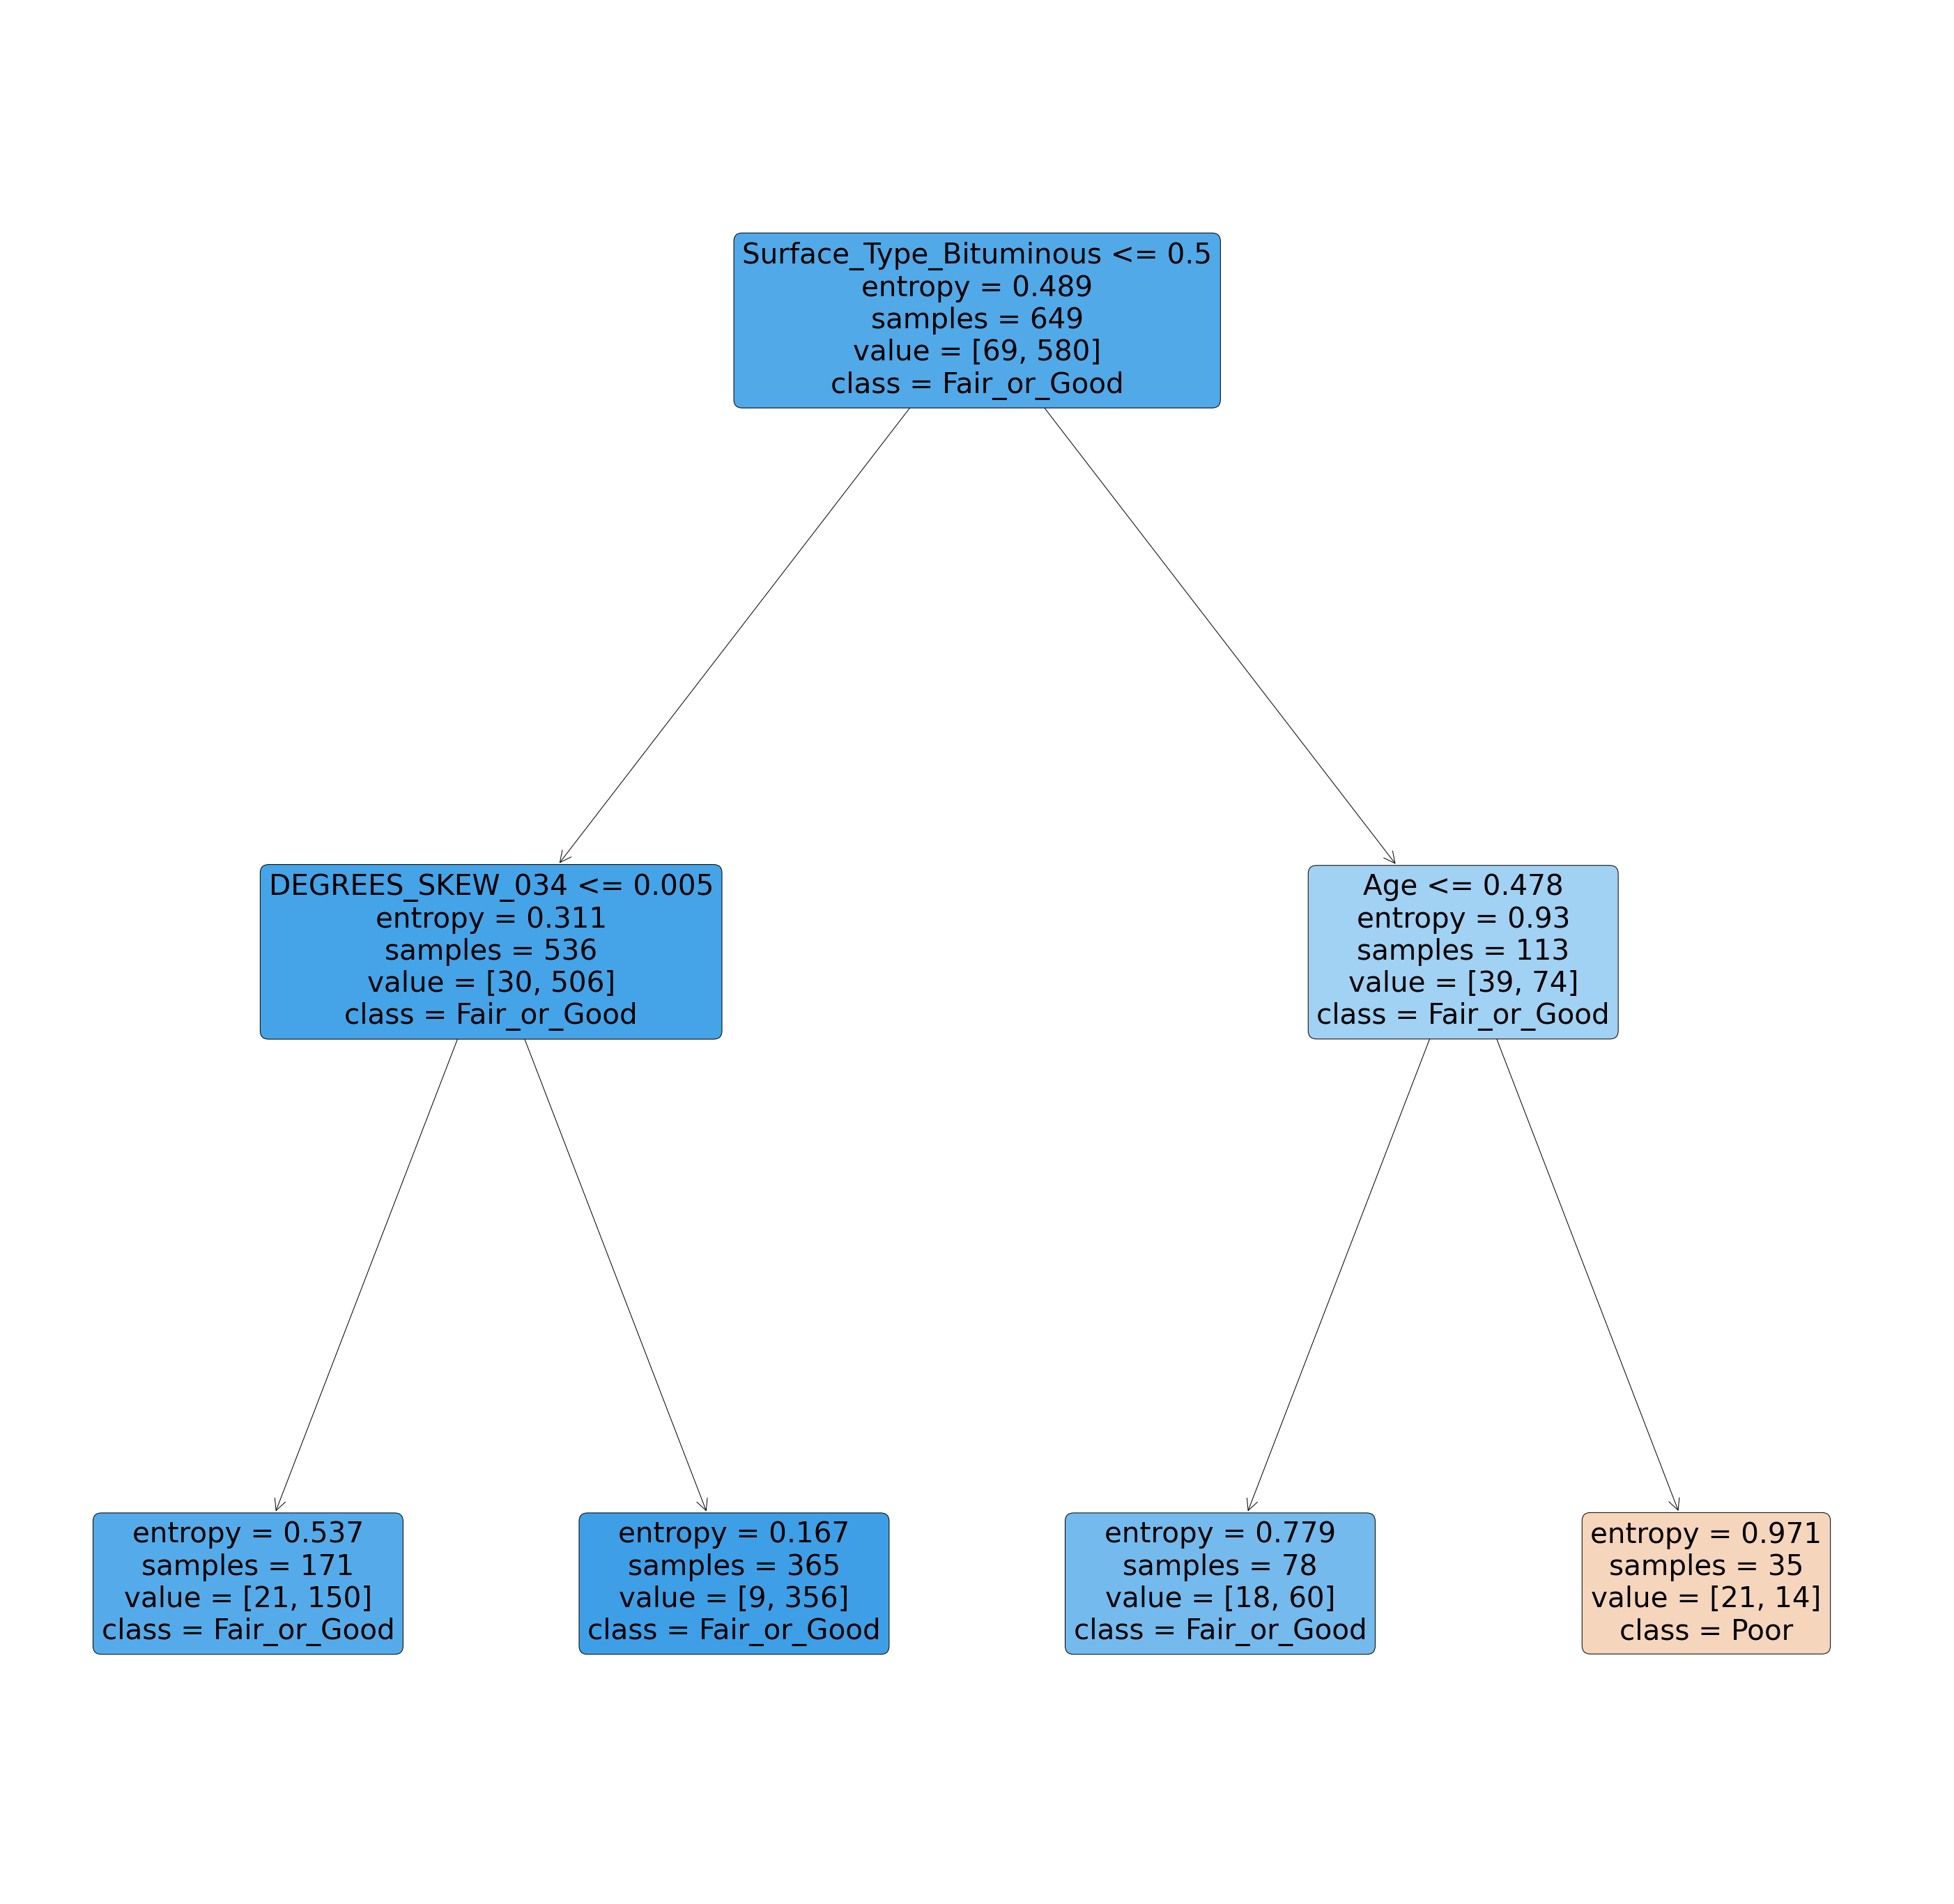

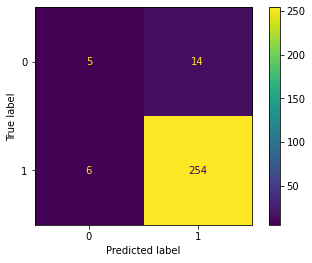

In [180]:
evaluate_CART(df)

## 3.3 Logistic Regression

In [186]:
def evaluate_logisticregression(df):
    y = df.loc[:, df.columns =='BRIDGE_CONDITION']
    X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    random_state=1)
    logbridge = LogisticRegression()
    logbridge.fit(X_train, y_train)
    y_pred = logbridge.predict(X_test)
    #print(y_pred)
    lr_accuracy = accuracy_score(y_test, y_pred)
    print('Logistic Regression Accuracy of Scikit Model: {:.3f}%'.format(lr_accuracy*100))
    cm_bridge = confusion_matrix(y_test,y_pred)
    #print(cm_bridge)
    print(classification_report(y_test, y_pred, digits=3))
    display_cm_bridge= ConfusionMatrixDisplay(confusion_matrix=cm_bridge, 
                                              display_labels=['Poor condition (0)',
                                                              'Fair or good condition (1)'])
    display_cm_bridge.plot()
    
#Should we add cross-validation to this?

Logistic Regression Accuracy of Scikit Model: 92.832%
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        19
           1      0.932     0.996     0.963       260

    accuracy                          0.928       279
   macro avg      0.466     0.498     0.481       279
weighted avg      0.868     0.928     0.897       279



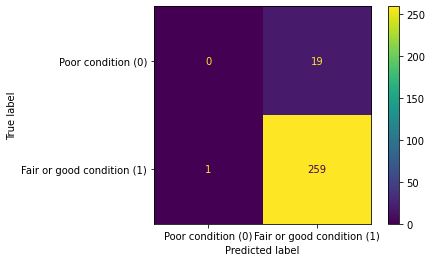

In [187]:
evaluate_logisticregression(df)